In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [2]:
from scipy.spatial.distance import cdist
def calculate_difference(source, target, age):
    interval = (age, age)

    source_copy = source.copy()
    source_copy = source_copy[source_copy.age.between(*interval)]
    source_copy = source_copy.drop('age', axis=1)

    target_copy = target.copy()
    target_copy = target_copy[target_copy.age.between(*interval)]
    target_copy = target_copy.drop('age', axis=1)

    source_min = source_copy.min()
    source_max = source_copy.max()

    source_copy = (source_copy - source_min) / (source_max - source_min)
    target_copy = (target_copy - source_min) / (source_max - source_min)

    distances = cdist(target_copy, source_copy, 'euclidean')

    minimals = np.argmin(distances, axis=1)
    errors = distances.transpose()[minimals].diagonal()
    return errors

In [3]:
my_semantic = [
    'stature',
    'waist-girth',
    'hip-girth',
    'thigh-girth',
    'calf-girth',
    'neck-girth',
    'bust-girth',
    'wrist-girth',
    'upper-arm-girth',
    'biacromial-length',
    'neck-to-waist-length',
    'waist-height',
    'croth-height'
]
life_semantic = [
    'height',
    'waist_gth',
    'hip_gth',
    'thigh_gth_r_hz',# 'thigh_gth_l_hz'
    'calf_gth_r', # calf_gth_l
    'mid_neck_gth',
    'bust_chest_gth',
    'wrist_gth',
    'up_arm_gth_r',
    'cr_shoulder',
    'neck_waist_c_back',
    'waist_ht',
    'crotch_ht'
]

In [4]:
my_male = np.load("curves-modules/bodies-male-measures.npy")
my_male = pd.DataFrame(my_male, columns=my_semantic)
my_male['thigh-girth'] /= 2
my_male['calf-girth'] /= 2

my_female = np.load("curves-modules/bodies-female-measures.npy")
my_female = pd.DataFrame(my_female, columns=my_semantic)
my_female['calf-girth'] /= 2
my_female['thigh-girth'] /= 2

In [5]:
life = pd.read_csv("curves-modules/datasets/life.csv",encoding_errors='ignore').dropna()
life_male = life[life['Gender'] == 'male']
life_male.columns = life_male.columns.str.lower()
life_male_age = life_male['age']
life_male = life_male[life_semantic]
life_male.columns = my_semantic

life_female = life[life['Gender'] == 'female']
life_female.columns = life_female.columns.str.lower()
life_female_age = life_female['age']
life_female = life_female[life_semantic]
life_female.columns = my_semantic

In [6]:
life_male_age.min(), life_male_age.max()

(18.0, 80.0)

In [7]:
life_female_age.min(), life_female_age.max()

(19.0, 81.0)

<AxesSubplot:ylabel='Frequency'>

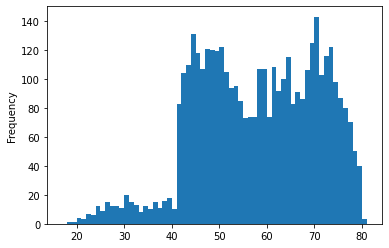

In [8]:
pd.Series(life_male_age).plot(kind='hist',bins=np.arange(17,82,1))

<AxesSubplot:ylabel='Frequency'>

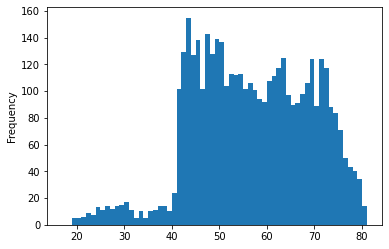

In [9]:
pd.Series(life_female_age).plot(kind='hist',bins=np.arange(17,82,1))

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
classificator = GradientBoostingRegressor

0.1235175786605438


<AxesSubplot:title={'center':'Generated bodies male'}, ylabel='Frequency'>

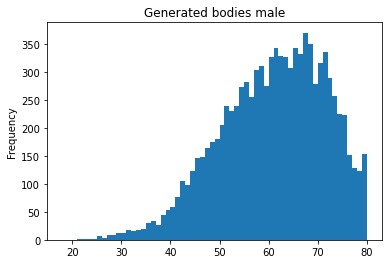

In [11]:
y = life_male_age
X = life_male
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = classificator(random_state=42, n_estimators=1000)
clf.fit(x_train,y_train)
y_generated = clf.predict(x_test)
my_male_age = np.rint(clf.predict(my_male))
print(mean_absolute_percentage_error(y_generated, y_test))
pd.Series(my_male_age).plot(kind='hist', bins=np.arange(18,81,1), title="Generated bodies male")

0.13019776862509222


<AxesSubplot:title={'center':'Generated bodies female'}, ylabel='Frequency'>

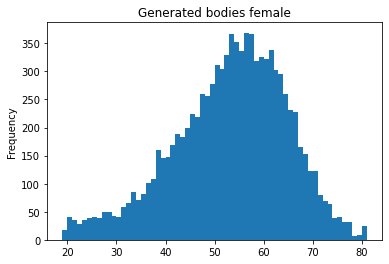

In [12]:
y = life_female_age
X = life_female
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
clf = classificator(random_state=42, n_estimators=1000)
clf.fit(x_train,y_train)
y_generated = clf.predict(x_test)
my_female_age = np.rint(clf.predict(my_female))
print(mean_absolute_percentage_error(y_generated, y_test))
pd.Series(my_female_age).plot(kind='hist', bins=np.arange(19,82,1), title="Generated bodies female")

In [13]:
my_male_copy = my_male.copy()
my_male_copy['age'] = my_male_age

life_male_copy = life_male.copy()
life_male_copy['age'] = life_male_age

min_age = life_male_copy.age.min()
max_age = life_male_copy.age.max()

values = []
interval = np.arange(min_age, max_age+1)
for age in interval:
    differences=calculate_difference(life_male_copy, my_male_copy, age)/13
    if differences.size > 0:
        values.append(differences.min())
    else:
        values.append(np.nan)
male_values = pd.Series(values, index=interval)
print(male_values.mean())

0.09240799695383575


In [14]:
my_female_copy = my_female.copy()
my_female_copy['age'] = my_female_age

life_female_copy = life_female.copy()
life_female_copy['age'] = life_female_age

min_age = life_female_copy.age.min()
max_age = life_female_copy.age.max()

values = []
interval = np.arange(min_age, max_age+1)
for age in interval:
    differences=calculate_difference(life_female_copy, my_female_copy, age)/13
    values.append(differences.min())
female_values = pd.Series(values, index=interval)
print(female_values.mean())

0.07601420322832136


In [15]:
female_values.isnull().sum()

1

In [16]:
male_values.isnull().sum()

3

<AxesSubplot:title={'center':'Age Prediction Error'}, xlabel='Age', ylabel='Percentual Error'>

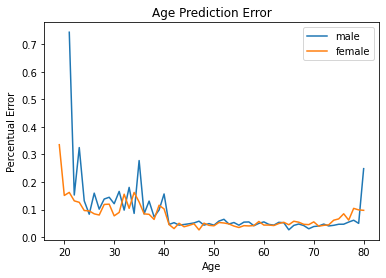

In [17]:
pd.DataFrame([male_values, female_values], index=['male', 'female']).T.plot(xlabel="Age", ylabel="Percentual Error", title="Age Prediction Error")